In [137]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
import matplotlib.pyplot as plt
from matplotlib import rc
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [138]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)

M = 1e3  # Big M

init = [1]

varying_list = [1.00, 1.16, 1.23, 1.17, 1.18, 1.02] + [0.78, 0.91, 0.89, 1.2, 1.14, 0.83]

varying_list = [i for i in varying_list for j in range(_time_intervals)]

demand_factor = pandas.DataFrame(data={'com1_sold': varying_list})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.58, 0.54, 0.07, 0.69, 0.17] + [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.26, 0.66, 0.28, 0.65, 0.01] + [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1]*6 + [0.06, 0.08, 0.08, 0.05, 0.1, 0.05]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1]*6 + [0.22, 0.04, 0.0, 0.1, 0.05, 0.02]})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [139]:
# pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0.75, 1.25), 2) for _ in range(_exec_scenarios-1)]})

In [140]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=175, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system', varying=[VaryingResource.DETERMINISTIC_DEMAND])

In [141]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=175, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.01, prod_min=175,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.01, prod_min=M,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=200, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=200, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=200, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=200, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=200, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=200, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=200, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Commodity 1 received from location 7')
com1_process = Process(name='com1_process', prod_max=200, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=150, capex=100, vopex=0.01, store_min=0, store_max= 10, prod_min=150,
                  label="Storage capacity of 10 units", storage=com1_in, storage_cost=1)

com1_store20 = Process(name='com1_store20', prod_max=150, capex=200, vopex=0.01, store_min=0,store_max= 20, prod_min=150,
                  label="Storage capacity of 20 units", storage=com1_in, storage_cost=2)

com1_store50 = Process(name='com1_store50', prod_max=150, capex=500, vopex=0.01, store_min=0, store_max= 50, prod_min=150,
                  label="Storage capacity of 50 units", storage=com1_in, storage_cost=5)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=200, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=200, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=200, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=200, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=200, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=200, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=200, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.01, prod_min=200,
                            label='Send commodity one from location 7')

In [142]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, demand_factor={com1_sold: demand_factor[['com1_sold']]})

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

# loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store10, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})
# 
# loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store10, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store10, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store10, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store20, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)
# 
# loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})
# 
# loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
#                 capacity_scale_level=0, availability_scale_level=0)

In [143]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=50)
truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=50)

truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=30)
truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=30, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=30)

truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=50)

truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=30)
truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=30, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=30)

truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=20)
truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=20, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=20)

truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.01, trans_min=100)
truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.01, trans_min=100)

truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=40)
truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=40)

truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=50)

truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=40)
truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=40, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=40)

In [144]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
    [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [145]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty = 500
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
scenario_resource_IS = Scenario(name='scenario_resource_IS', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=0, demand_scale_level=1, capacity_scale_level=0,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Scenario with full information sharing for resource variability', annualization_factor=(1/12))

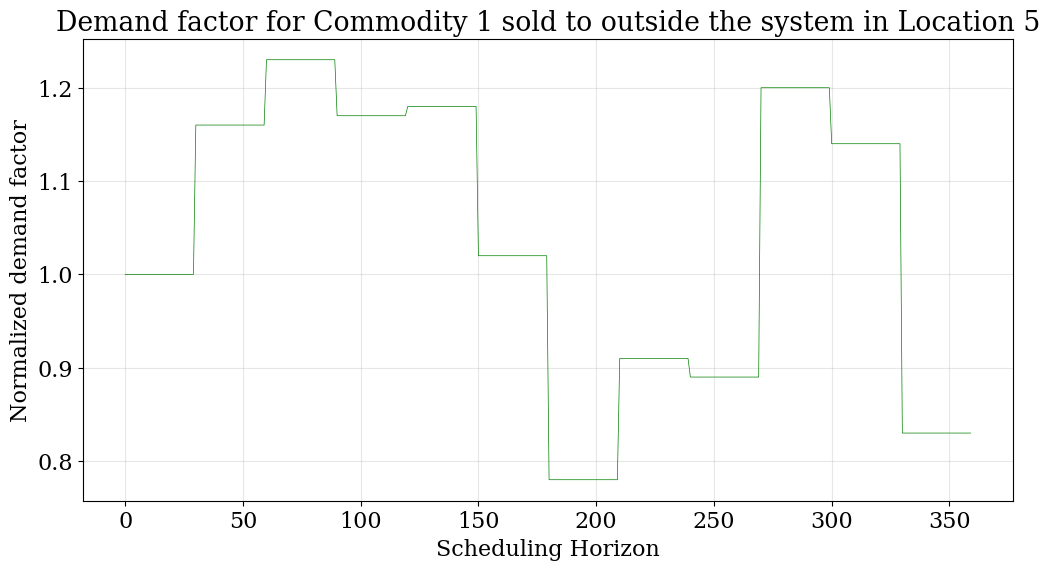

In [146]:
plot_scenario.demand_factor(scenario=scenario_resource_IS, resource=com1_sold, location=loc5, color='green')

In [147]:
# import matplotlib.pyplot as plt
# from matplotlib import rc
# 
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
# rc('text', usetex=False)
# 
# fig, ax = plt.subplots()
# 
# # Plot data from the first dataset
# ax.plot(range(len(scenario_resource_IS.availability_factor['loc1']['com1_pur'].values())), scenario_resource_IS.availability_factor['loc1']['com1_pur'].values(), label='Location 1',
#         color='blue', marker='o')
# 
# ax.plot(range(len(scenario_resource_IS.availability_factor['loc6']['com1_pur'].values())), scenario_resource_IS.availability_factor['loc6']['com1_pur'].values(), label='Location 6',
#         color='red', marker='x')
# # Customize the plot
# ax.set_xlabel('Time Horizon')
# ax.set_ylabel('Normalized Availability Factor')
# ax.set_title('Resource Availability factor')
# ax.legend()
# ax.plot(linewidth=0.5)
# plt.grid(alpha=0.3)
# plt.rcdefaults()
# # Show the plot
# plt.show()

In [148]:
problem_mincost = formulate(scenario=scenario_resource_IS,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint demand penalty
objective cost w demand penalty


In [149]:
results_mincost = solve(scenario=scenario_resource_IS, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1003956 rows, 2876965 columns and 1392723 nonzeros
Model fingerprint: 0x39409b54
Variable types: 2866381 continuous, 10584 integer (10584 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 1.907523e+07
Presolve removed 998204 rows and 2861142 columns
Presolve time: 0.80s
Presolved: 5752 rows, 15823 columns, 30561 nonzeros
Variable types: 15823 continuous, 0 integer (0 binary)

Root relaxation: objective 5.924300e+05, 4836 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

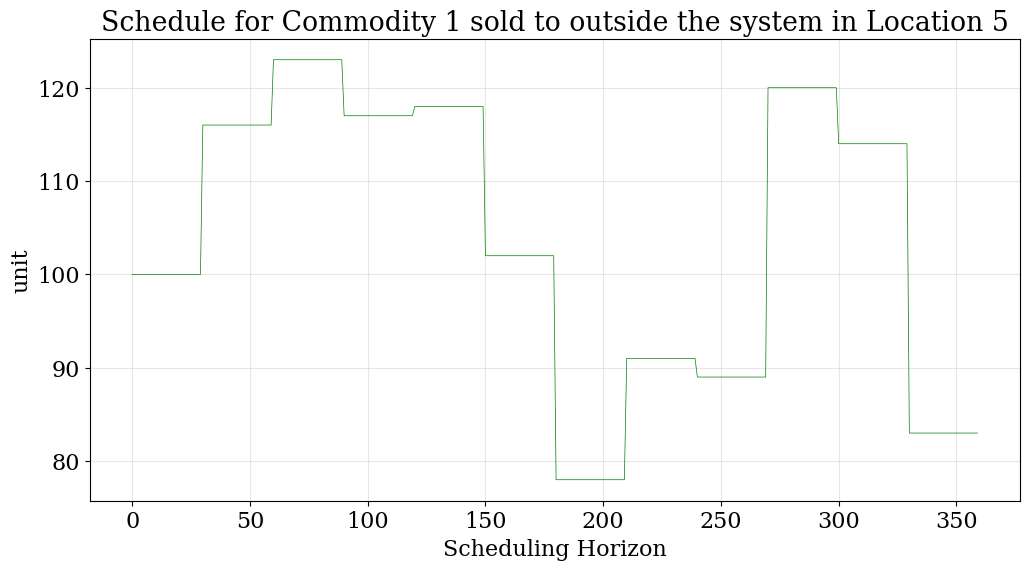

In [150]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [151]:
sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/(100*_time_intervals*_exec_scenarios)

1.0425

In [152]:
min(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')

78.0

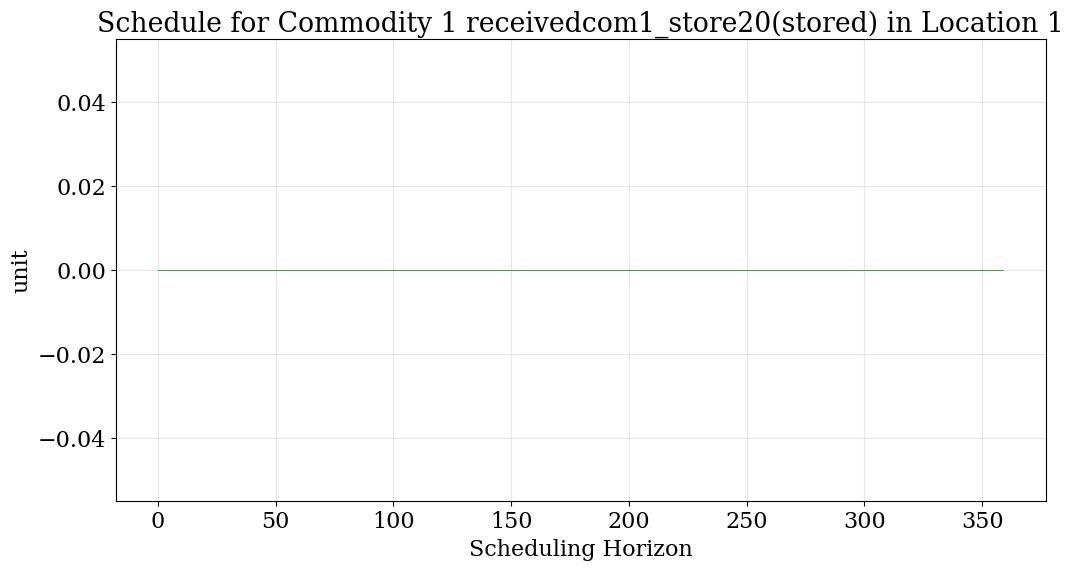

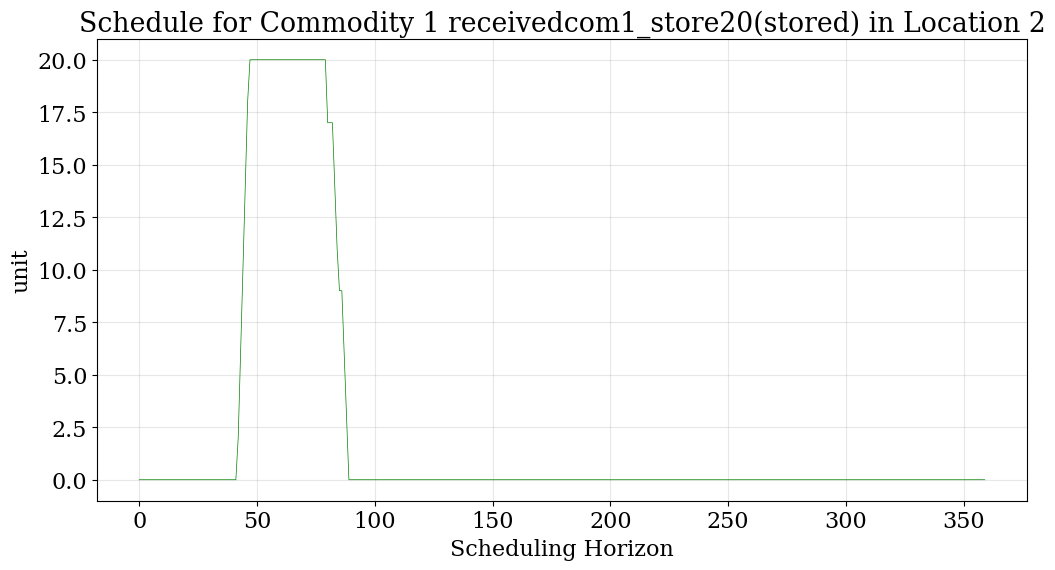

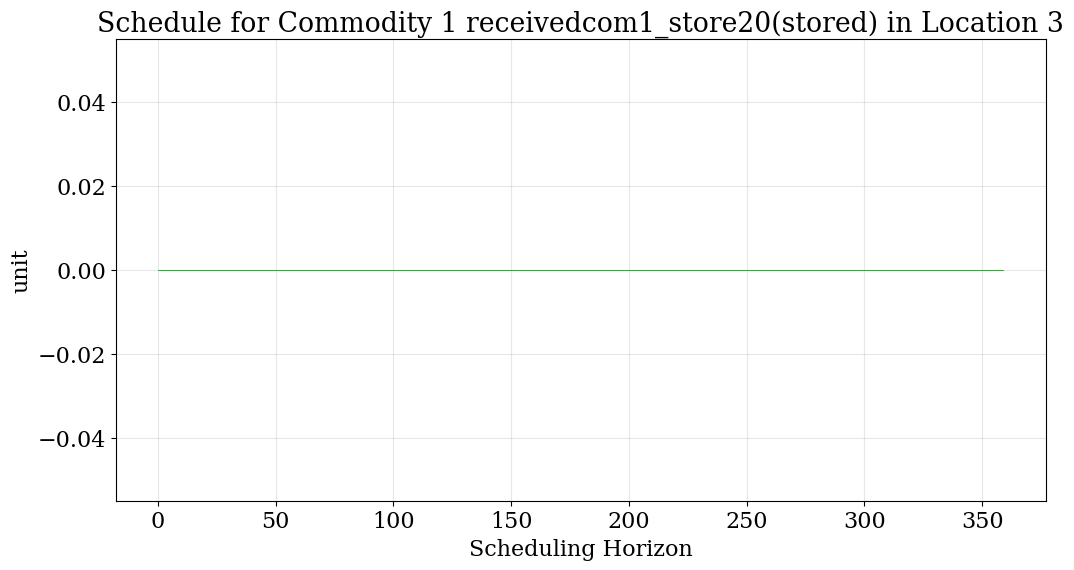

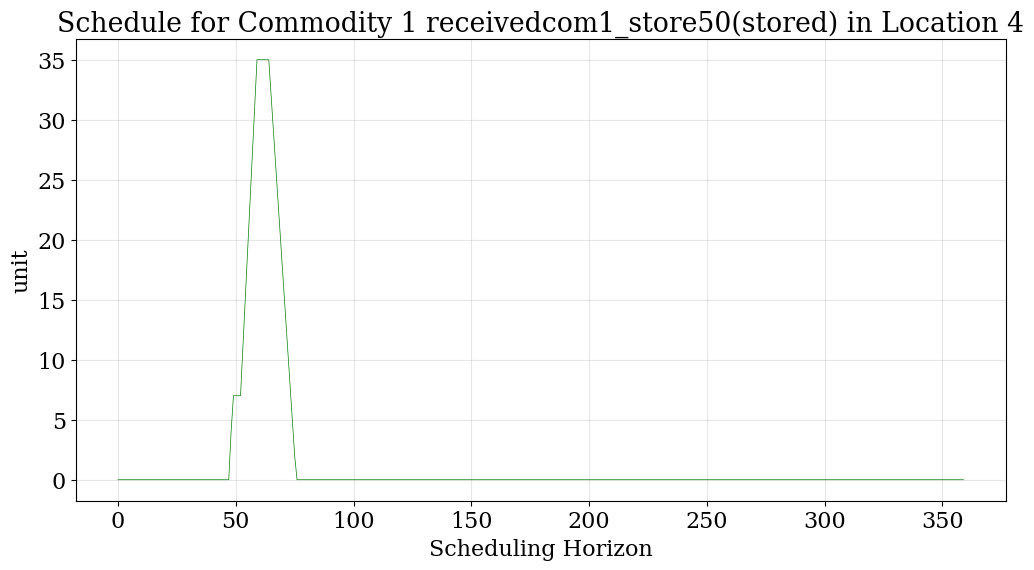

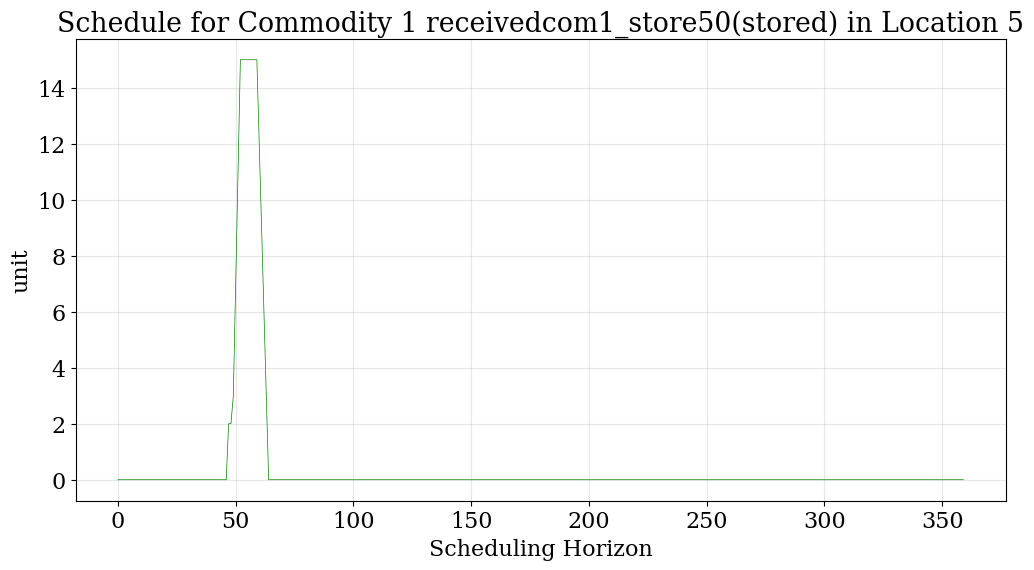

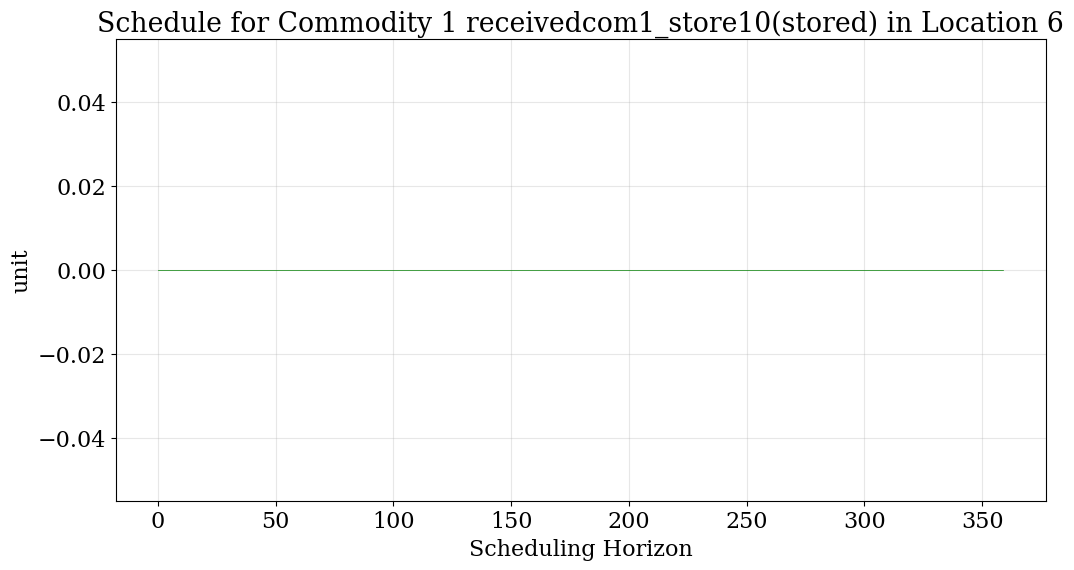

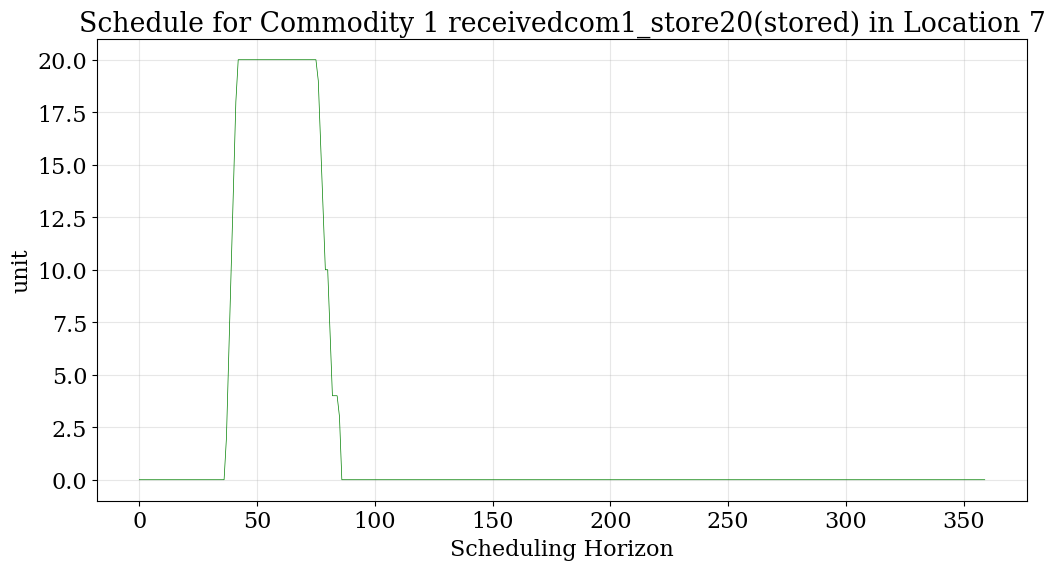

In [153]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc1', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc2', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc3', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc4', color='green')
# plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc5', color='green')

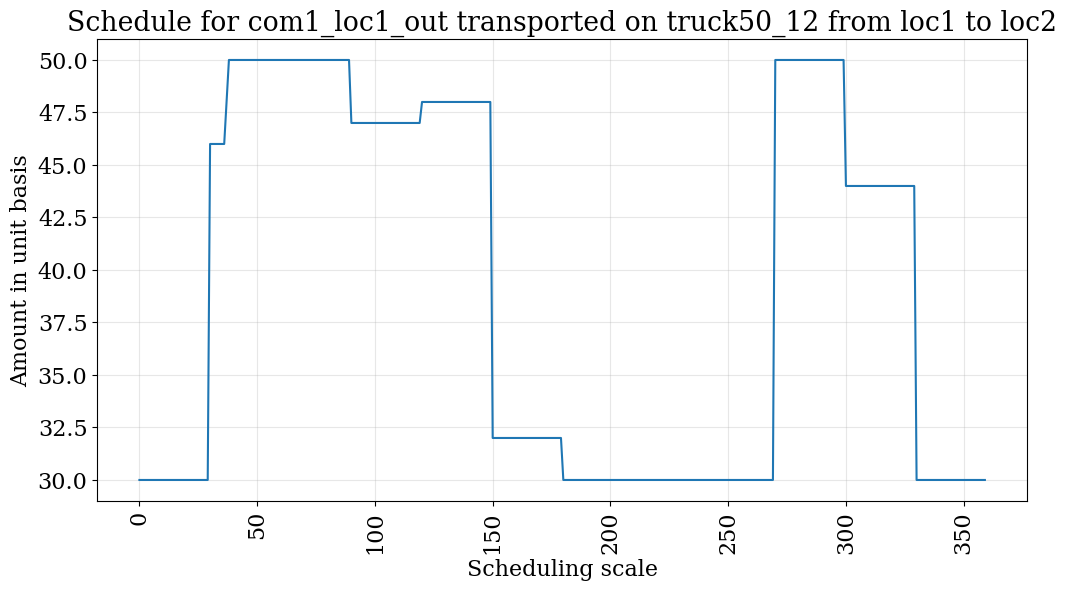

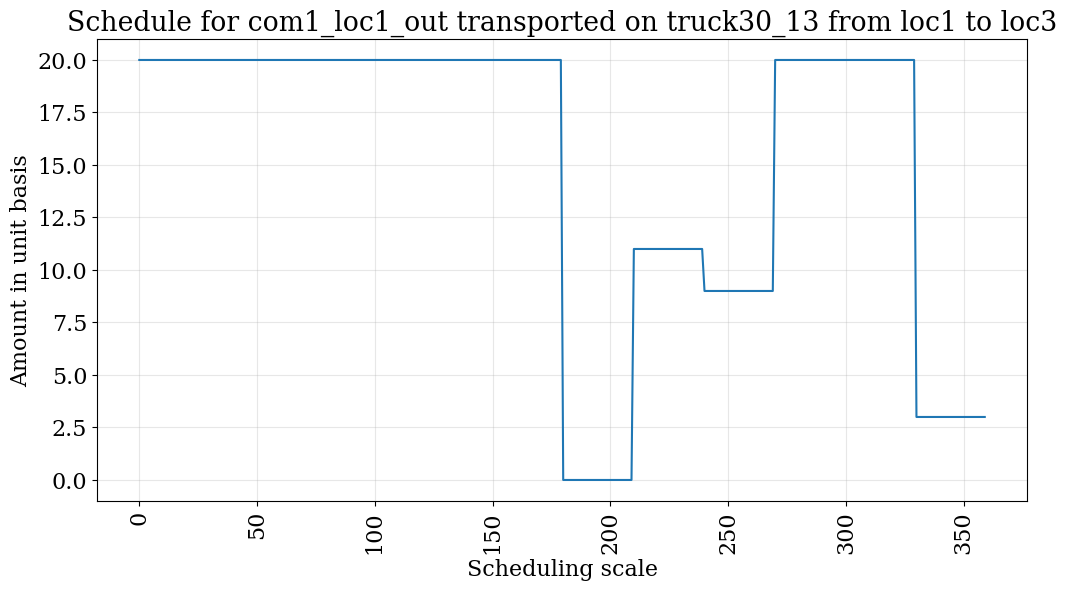

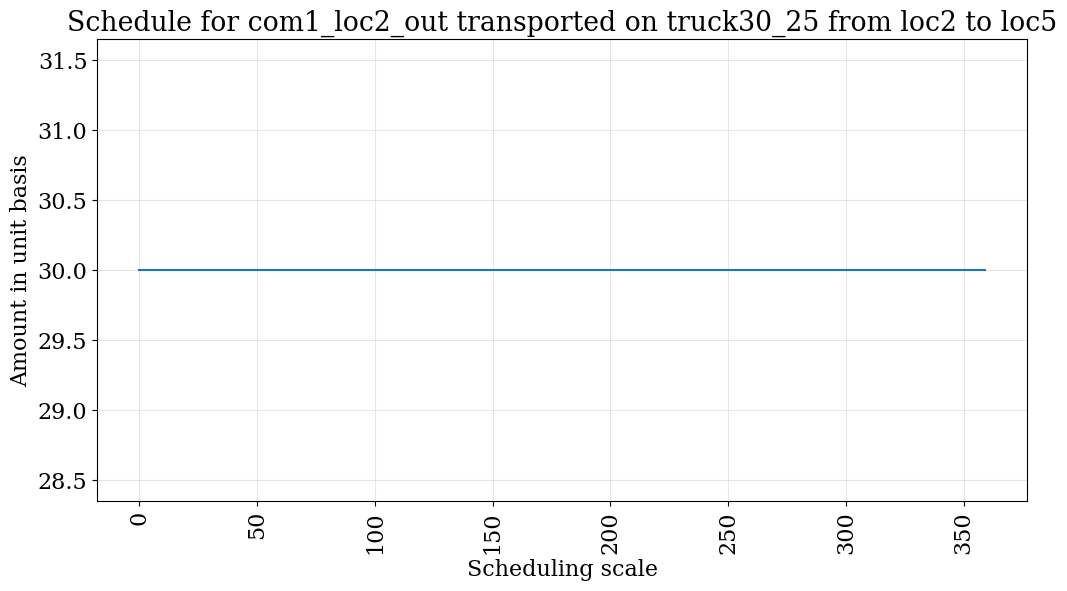

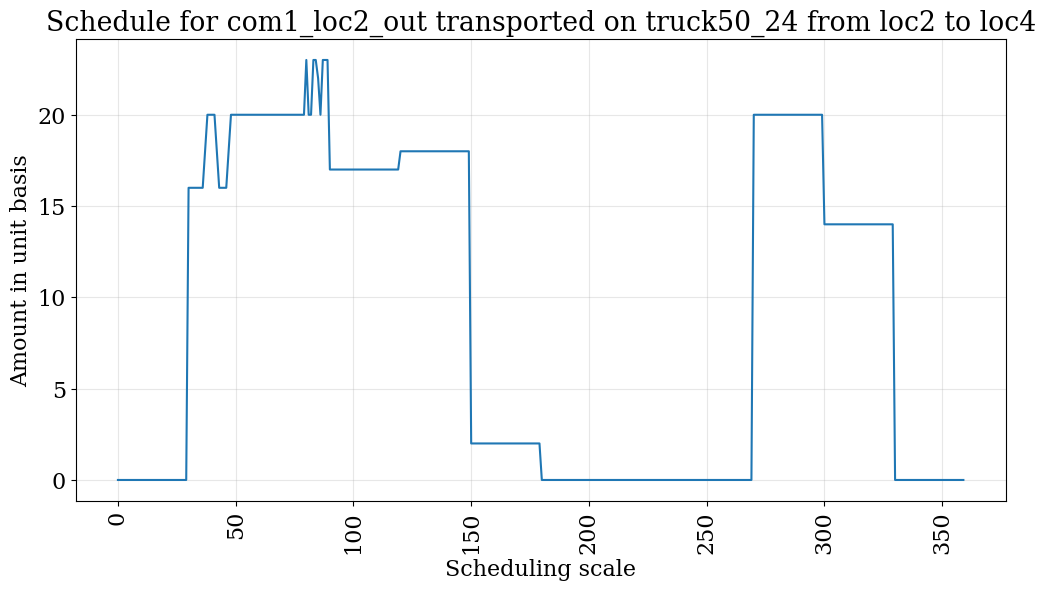

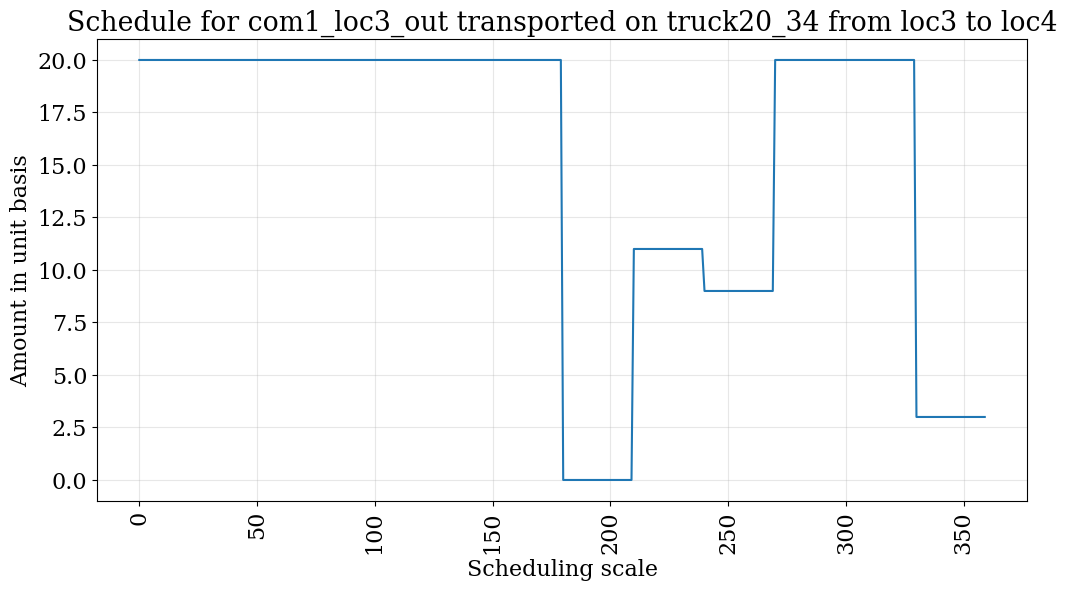

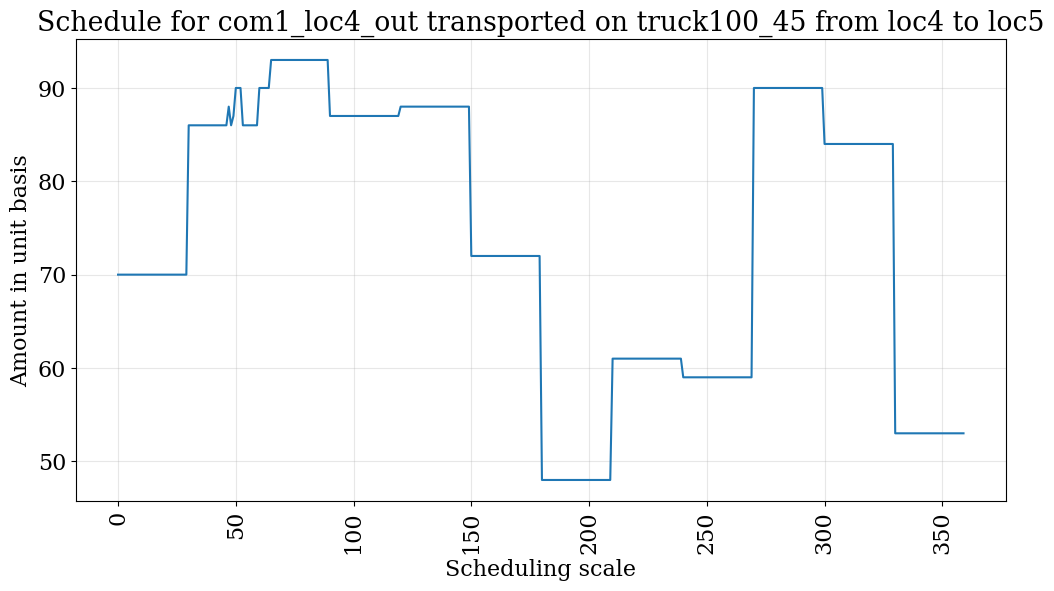

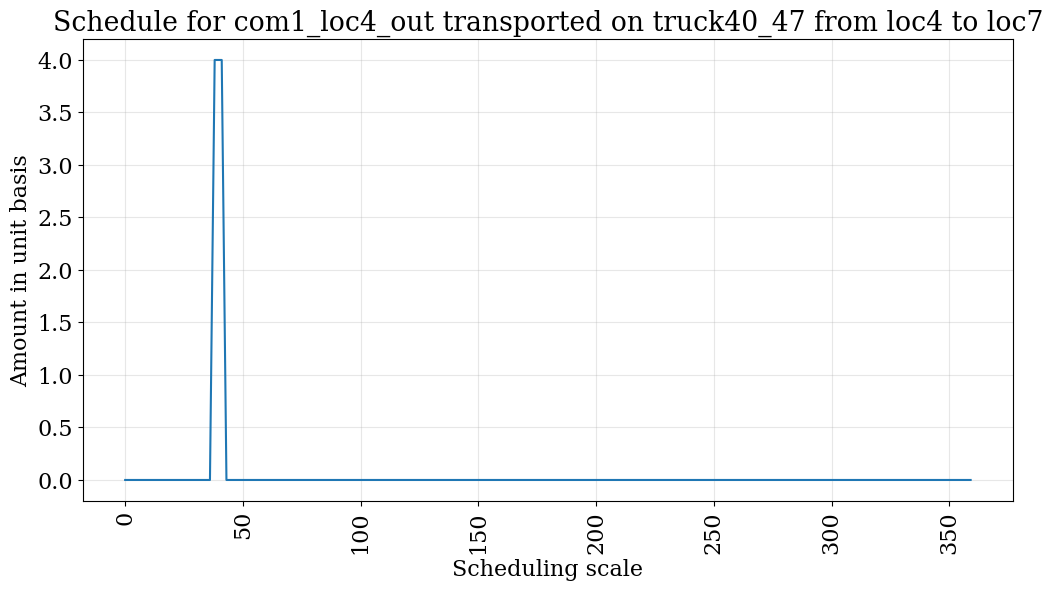

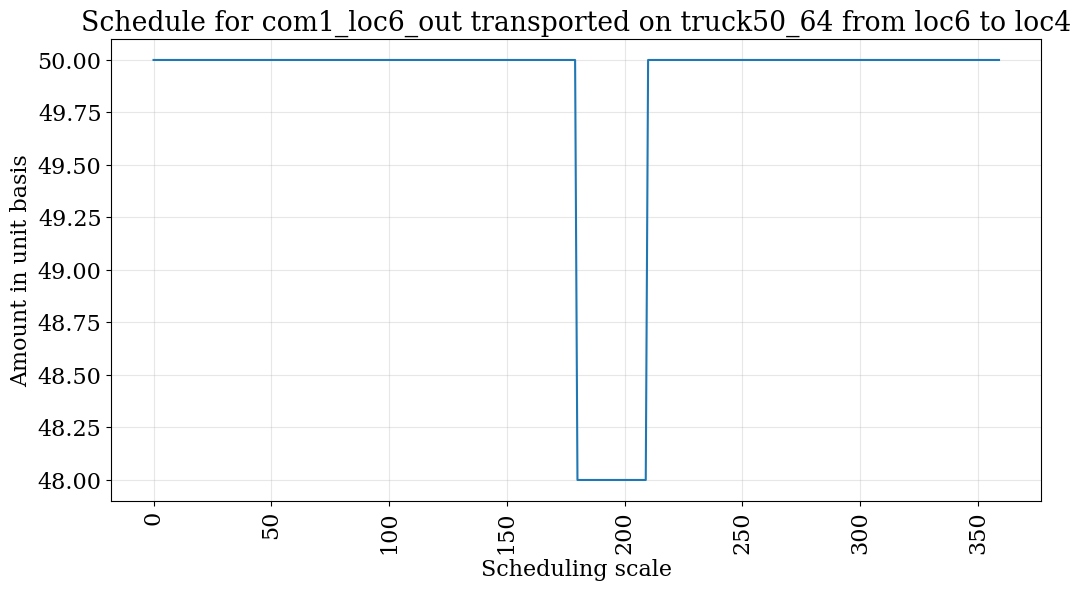

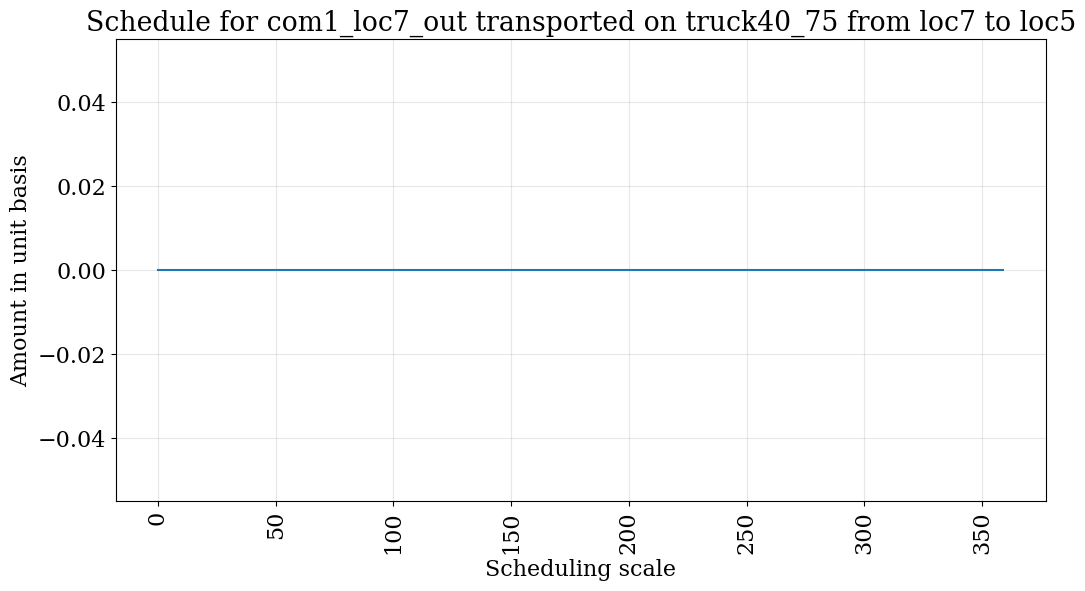

In [154]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')

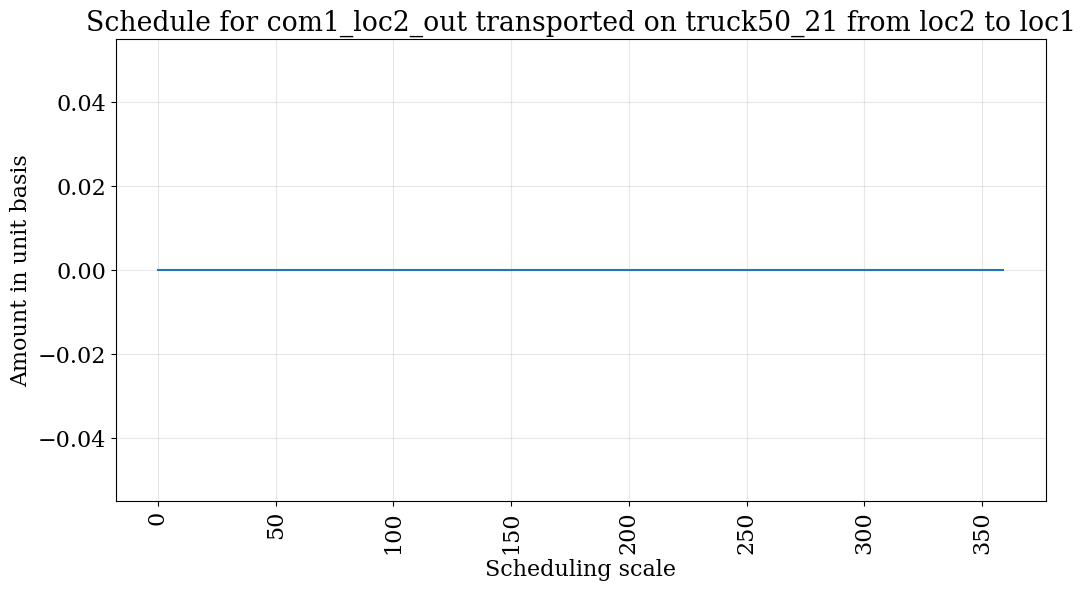

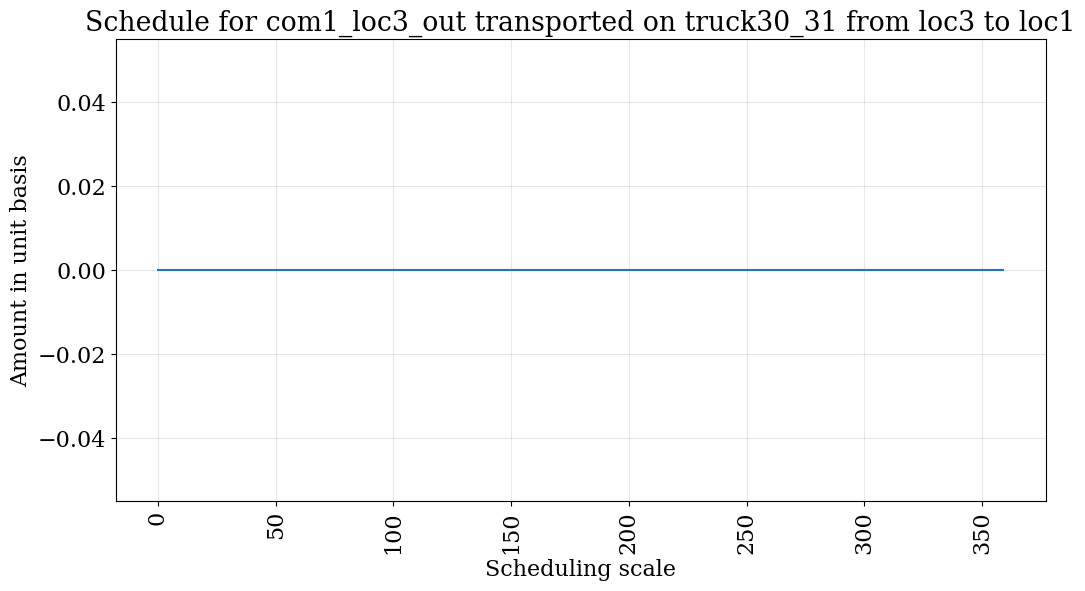

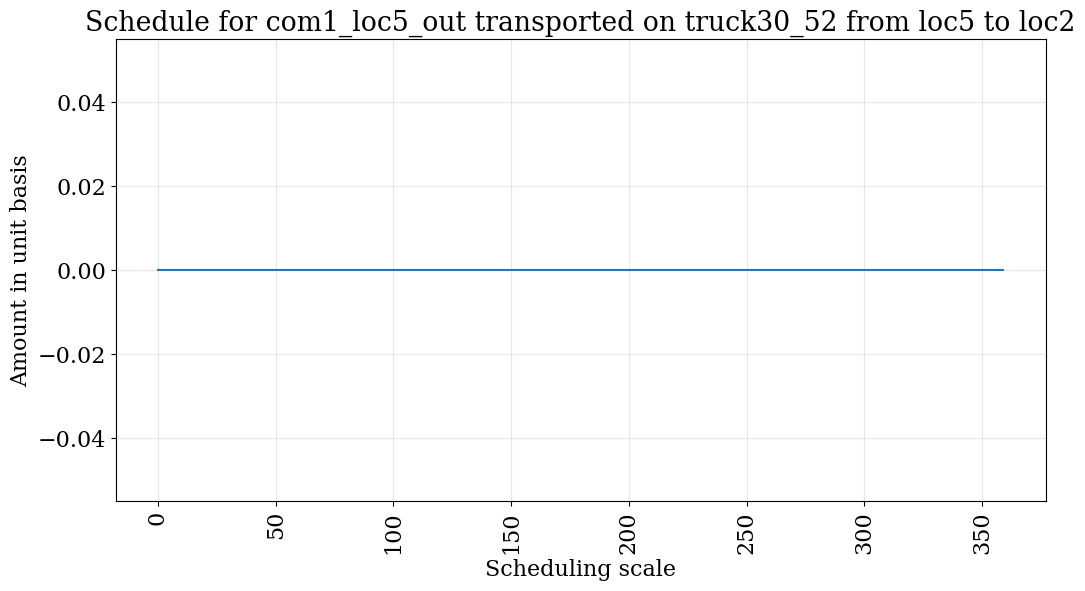

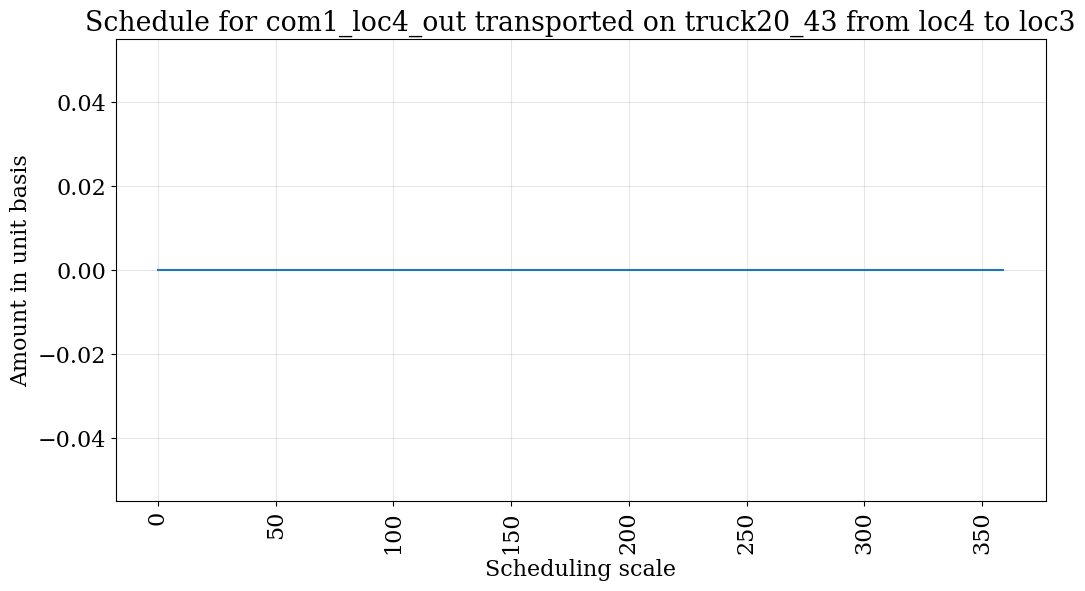

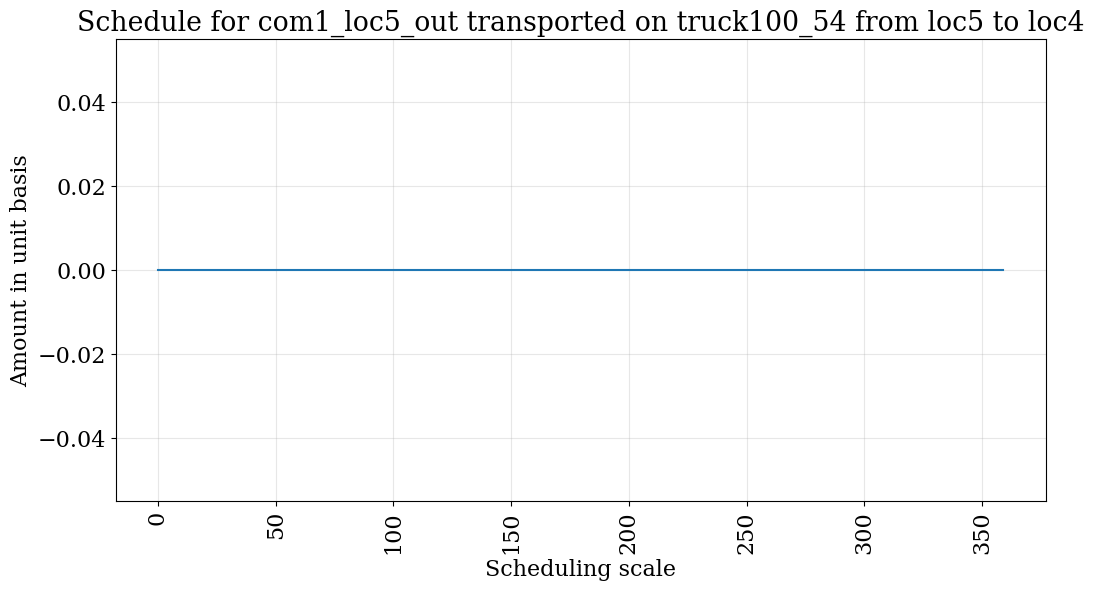

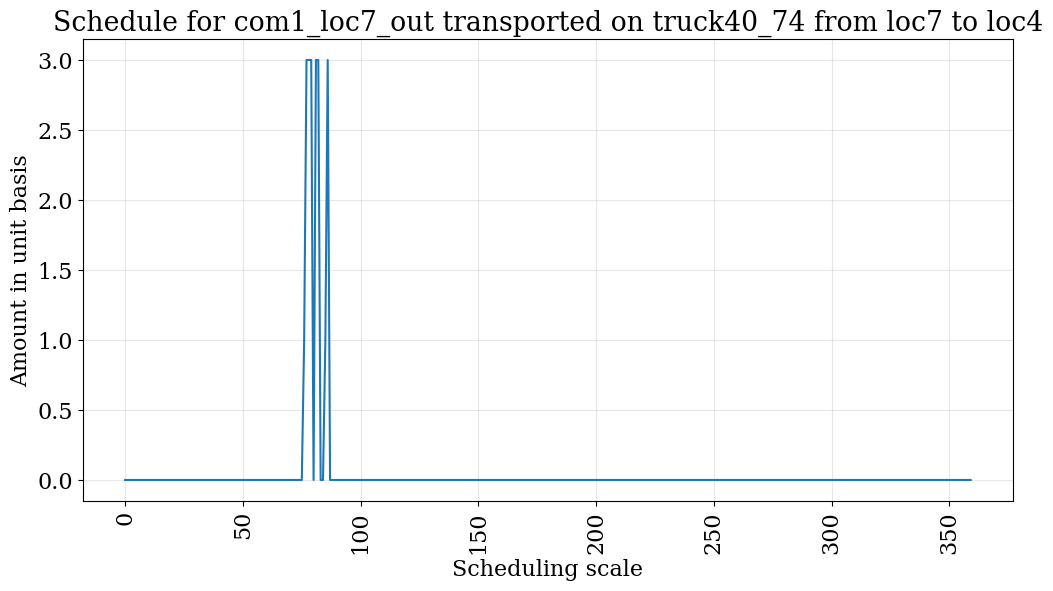

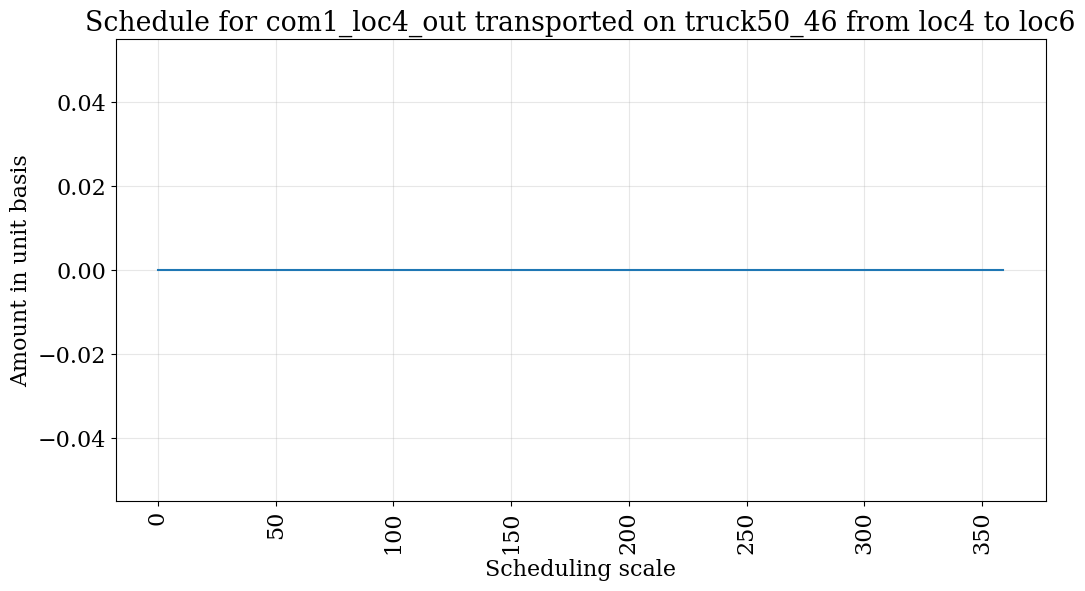

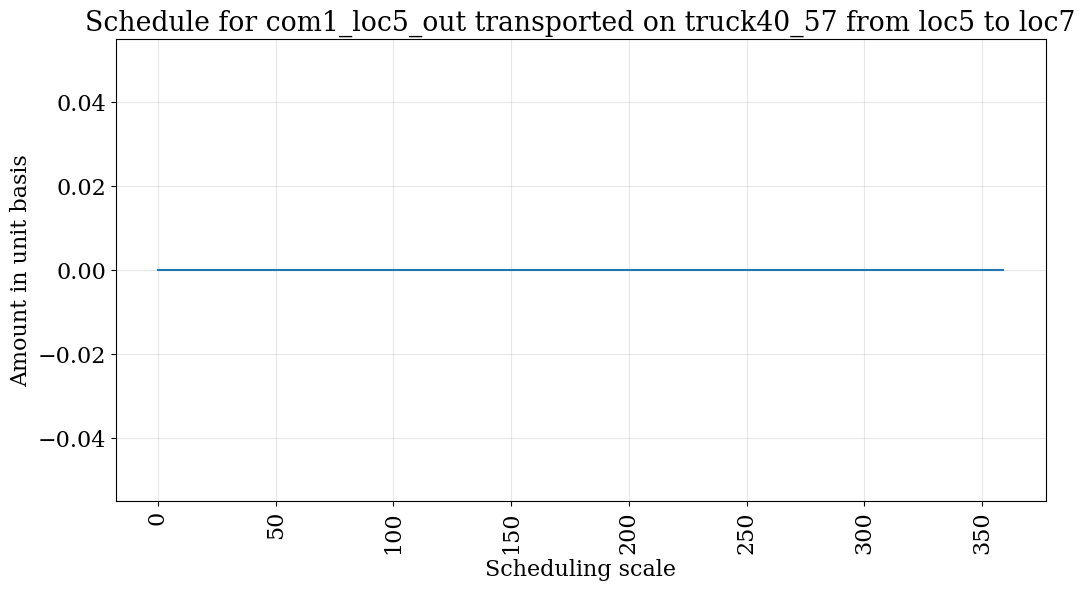

In [155]:
plot_results.transport(results=results_mincost, source='loc2', sink='loc1', transport='truck50_21',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc1', transport='truck30_31',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc2', transport='truck30_52',
                       resource='com1_loc5_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc3', transport='truck20_43',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc4', transport='truck100_54',
                       resource='com1_loc5_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc4', transport='truck40_74',
                       resource='com1_loc7_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc6', transport='truck50_46',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc7', transport='truck40_57',
                       resource='com1_loc5_out')

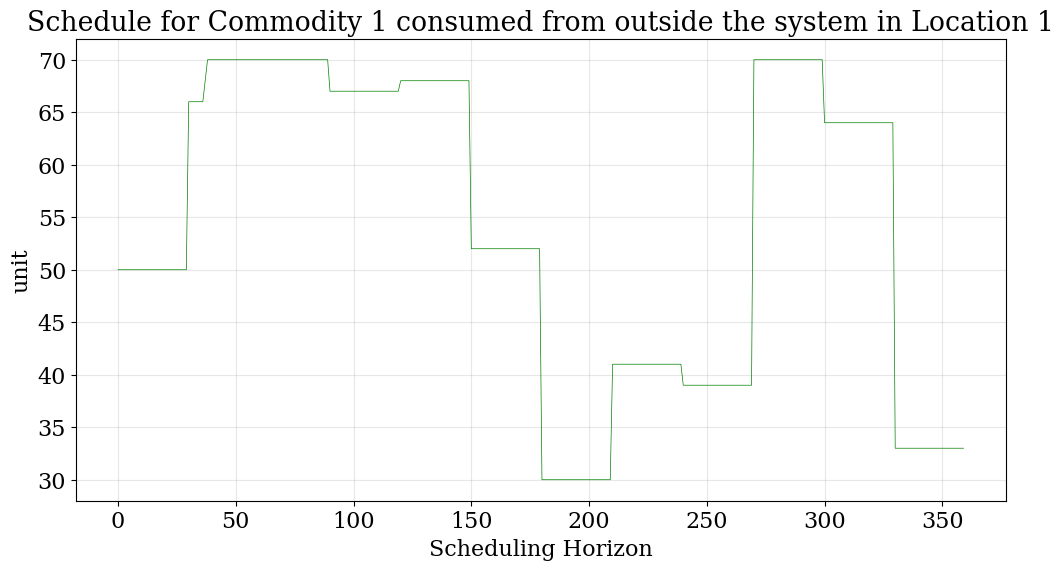

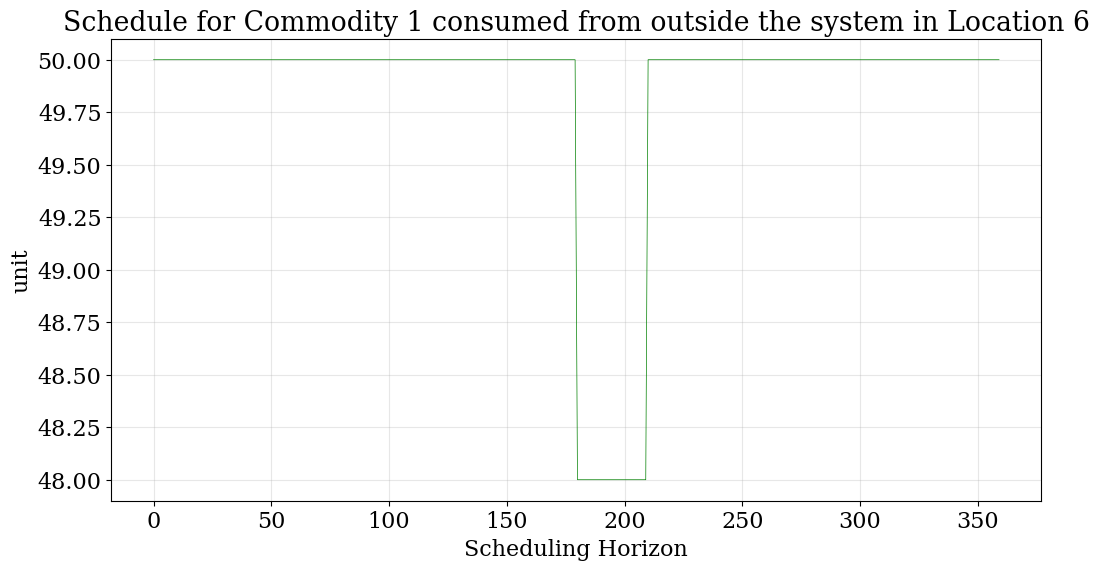

In [156]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [157]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()

Capex_network : Capex at network scale
    Size=12, Index=scales_network
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      0 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      1 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      2 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      3 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      4 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      5 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      6 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      7 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      8 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
      9 :     0 : 23814.58333333333 :  None : False : False : NonNegativeReals
     10 :     0 : 23814.58333333333 :  None : False : False : NonNeg

In [158]:
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=12, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      1 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      2 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      3 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      4 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      5 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      6 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      7 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      8 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      9 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
     10 :     0 : 203

In [159]:
results_mincost.output['objective']

592429.9630000002

In [160]:
sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<= 5) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=5)*demand_penalty

307595.7815

In [161]:
sum(value for key, value in results_mincost.output['Capex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]>=6)*demand_penalty

277918.18149999995

In [162]:
inventory_zero = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 6, 0)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 6, 0)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 6, 0)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 6, 0)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 6, 0)]}
                  }

inventory_zero

# inventory6 = {loc1: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc2: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc3: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc4: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store10.resource_storage.name, 6, 0)]},
#                   loc5: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store20.resource_storage.name, 6, 0)]},
#                   }
# inventory6

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [163]:
results_mincost.output['objective']

592429.9630000002

In [168]:
cost = sum(value for key, value in results_mincost.output['Vopex_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items())*demand_penalty+\
sum(value for key, value in results_mincost.output['Capex_network'].items())+\
sum(value for key, value in results_mincost.output['Capex_transport_network'].items())+\
sum(value for key, value in results_mincost.output['Inv_cost'].items())

cost

592429.9629999999

In [165]:
# print([(key, value) for key, value in results_mincost.output['Demand_penalty'].items() if value!=0])

In [166]:
# problem_mincost_2 = formulate(scenario=scenario_resource,
#                               constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
#                                            Constraints.PRODUCTION, Constraints.INVENTORY, Constraints.DEMAND},
#                               demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
# 
# min_demand_satisfaction_2 = 40
# min_demand_dict_2 = {i: {com1_sold: min_demand_satisfaction_2} if i == loc5 else {com1_sold: 0} for i in locset}
# 
# min_demand_6 = min_demand_dict_2
# if isinstance(min_demand_6, dict):
#     if isinstance(list(min_demand_6.keys())[0], Location):
#         try:
#             min_demand_6 = {i.name: {
#                 j.name: min_demand_6[i][j] for j in min_demand_6[i].keys()} for i in min_demand_6.keys()}
#         except:
#             pass
# 
# problem_mincost_2.del_component(constraint_demand2)
# problem_mincost_2.constraint_demand2 = constraint_demand2(instance=problem_mincost_2, demand=min_demand_6,
#                                                           demand_factor=scenario_resource.demand_factor,
#                                                           demand_scale_level=scenario_resource.demand_scale_level,
#                                                           scheduling_scale_level=scenario_resource.scheduling_scale_level,
#                                                           cluster_wt=None, loc_res_dict=None, sign='geq')
# 
# results_mincost_2 = solve(scenario=scenario_resource, instance=problem_mincost_2, solver='gurobi', name='MILP')

In [167]:
sum(value for key, value in results_mincost_2.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')/(100*_time_intervals*_exec_scenarios)

NameError: name 'results_mincost_2' is not defined

In [ ]:
min(value for key, value in results_mincost_2.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [ ]:
problem_mincost_2.Capex_network.pprint()
problem_mincost_2.Fopex_network.pprint()
problem_mincost_2.Vopex_network.pprint()
problem_mincost_2.Capex_transport_network.pprint()
problem_mincost_2.Fopex_transport_network.pprint()
problem_mincost_2.Vopex_transport_network.pprint()

In [ ]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))), list(value for key, value in results_mincost_2.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Commodity sold')
ax.set_title('Commodity 1 sold at Location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc1' and key[1]=='com1_store20_com1_in_stored'), label='46_min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc2' and key[1]=='com1_store20_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 2')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc3' and key[1]=='com1_store20_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 3')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc4' and key[1]=='com1_store50_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 4')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc5' and key[1]=='com1_store50_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 5')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc6' and key[1]=='com1_store10_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 6')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'), label='No Min', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'))), list(value for key, value in results_mincost_2.output['Inv'].items() if key[0]=='loc7' and key[1]=='com1_store20_com1_in_stored'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Inventory level')
ax.set_title('Inventory levels for Commodity 1 at Location 7')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

In [ ]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc2'and key[2]=='truck50_12'and key[3]=='com1_loc1_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc2 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc1' and key[1]=='loc3'and key[2]=='truck30_13'and key[3]=='com1_loc1_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc1 and loc3 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc4'and key[2]=='truck50_24'and key[3]=='com1_loc2_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc2' and key[1]=='loc5'and key[2]=='truck30_25'and key[3]=='com1_loc2_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc2 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc3' and key[1]=='loc4'and key[2]=='truck20_34'and key[3]=='com1_loc3_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc3 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc5'and key[2]=='truck100_45'and key[3]=='com1_loc4_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc4' and key[1]=='loc7'and key[2]=='truck40_47'and key[3]=='com1_loc4_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc4 and loc7 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc6' and key[1]=='loc4'and key[2]=='truck50_64'and key[3]=='com1_loc6_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc6 and loc4 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()

####################################################################################################################################################################################

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=False)

fig, ax = plt.subplots()

# Plot data from the first dataset
ax.plot(range(len(list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='Baseline', color='blue')

ax.plot(range(len(list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'))), list(value for key, value in results_mincost_2.output['Exp'].items() if key[0]=='loc7' and key[1]=='loc5'and key[2]=='truck40_75'and key[3]=='com1_loc7_out'), label='46 Min', color='green')

# Customize the plot
ax.set_xlabel('Time Horizon')
ax.set_ylabel('Transport level')
ax.set_title('Transport between loc7 and loc5 for commodity 1')
ax.legend()
ax.plot(linewidth=0.5)
plt.grid(alpha=0.3)
plt.rcdefaults()
# Show the plot
plt.show()